<a href="https://colab.research.google.com/github/bailu-bot/CodeBank/blob/main/clustering/kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

In this notebook we'll take a look at how we can cluster a set of chemical structures using the k-means algorithm. **It's important to note that there is a stochastic component to k-means clusterinh.  The results you see may differ from the published version of this notebook.**

Install the necessary Python libraries

In [102]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install useful_rdkit_utils pandas scikit-learn tqdm numpy seaborn mols2grid matplotlib

Import the necessary Python libraries

In [103]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import mols2grid
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Enable Pandas [progress_apply](https://towardsdatascience.com/progress-bars-in-python-and-pandas-f81954d33bae)

In [104]:
tqdm.pandas()

In [105]:
import matplotlib.pyplot as plt

Set up Seaborn plot aesthetics

In [106]:
sns.set()
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

Read the input data

In [107]:
smiles_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/cluster_test.smi"
df = pd.read_csv(smiles_url,sep=" ",names=["SMILES","Name"])

Add molecular fingerprints to the dataframe

In [108]:
smi2fp = uru.Smi2Fp()
df['fp'] = df.SMILES.progress_apply(smi2fp.get_np)

  0%|          | 0/735 [00:00<?, ?it/s]

In [109]:
print(df.columns)

Index(['SMILES', 'Name', 'fp'], dtype='object')


Convert the fingerprints to an X matrix to make sklearn happy

In [110]:
X = np.stack(df.fp)

查看一下df的内容

In [147]:
df.head(5)

,SMILES,Name,fp
0,CCC(=O)/N=C1\S[C@H]2CS(=O)(=O)C[C@@H]2N1c1ccc(...,16741133,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1ccc(Cl)cc1N1/C(=N\C(=O)CCC(=O)O)S[C@H]2CS(=...,101303273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCCCC(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@@H]2N1c1cc...,32504126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CCN(CC)c1ccc(N2/C(=N\C(=O)CC#N)S[C@H]3CS(=O)(=...,101319242,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC[C@H](C)C(=O)/N=C1/S[C@H]2CS(=O)(=O)C[C@H]2N...,36638719,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


查看SMILES是否有重复

In [159]:
df_copy=df.groupby('SMILES')['fp']
print(type(df_copy))
print(len(df))
print(len(df_copy))

<class 'pandas.core.groupby.generic.SeriesGroupBy'>
735
735


使用层次聚类

In [111]:
import scipy.cluster.hierarchy as shc
Z=shc.linkage(np.stack(X), method='ward')

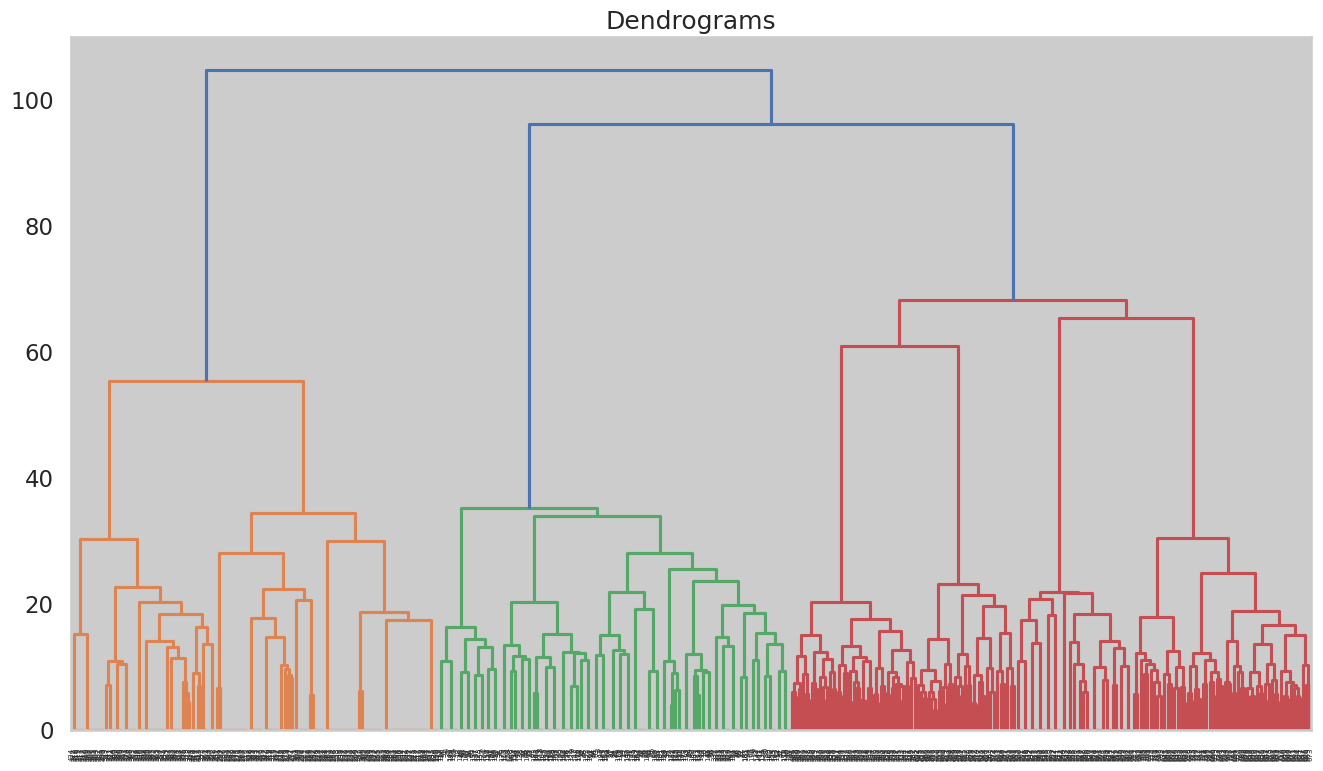

In [148]:

plt.figure(figsize=(16, 9))
plt.title("Dendrograms")
dend = shc.dendrogram(Z)

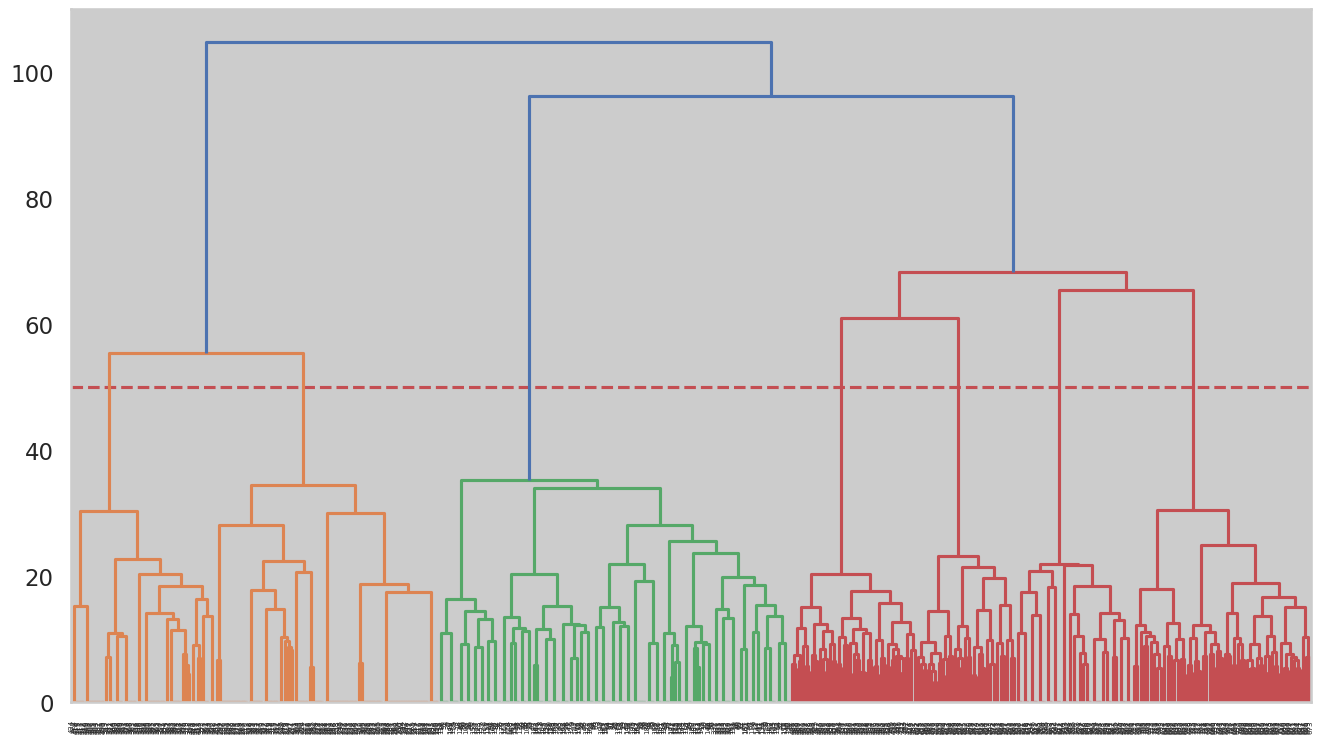

In [165]:
plt.figure(figsize=(16, 9))
plt.axhline(y=50, color='r', linestyle='--')
dend = shc.dendrogram(Z)

In [114]:
def get_newick(node, parent_dist, leaf_names, newick=''):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parent_dist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, "," + newick)
        newick = "(" + newick
        return newick

from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist

In [144]:
tree = to_tree(Z, rd=False)
labels = [df['SMILES'][i] for i in range(len(X))]  # 给每个样本命名
#保存为.nwk
newick_str = get_newick(tree, tree.dist, labels)
with open("tree.nwk", "w") as f:
    f.write(newick_str)

In [116]:
from sklearn.cluster import AgglomerativeClustering
cluster= AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
cluster_list=cluster.fit_predict(X)

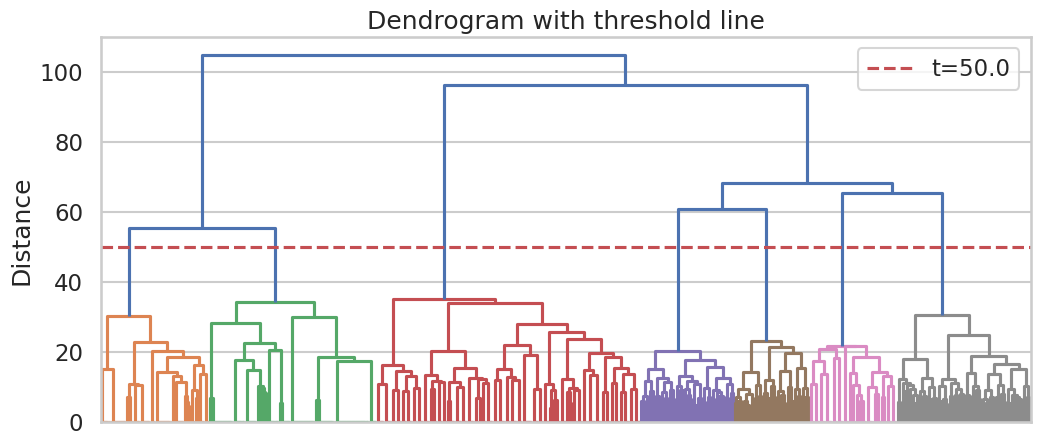

In [117]:
# 3) 在树上画一条横线作为阈值（你可以修改 t_distance）
t_distance = 50.0  # 例子阈值，按你的 dendrogram 看具体改动
plt.figure(figsize=(12, 5))
dend = dendrogram(Z, no_labels=True, color_threshold=t_distance)
plt.axhline(y=t_distance, color='r', linestyle='--', label=f't={t_distance}')
plt.legend()
plt.ylabel("Distance")
plt.title("Dendrogram with threshold line")
plt.show()

In [118]:
# 4a) 按距离阈值截树 -> 得到标签
labels_by_distance = fcluster(Z, t=50, criterion='distance')  # labels 从1开始
# 若想要 0-based labels：
labels_by_distance0 = labels_by_distance - 1
print(labels_by_distance)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [119]:
# 4b) 或者按目标簇数截树（例如你想要 k 个簇）
k = 5
labels_by_k = fcluster(Z, t=k, criterion='maxclust')  # labels 也是从1开始
labels_by_k0 = labels_by_k - 1


In [120]:
# 5) 自动建议阈值/簇数（基于 linkage 中距离的最大跳跃）
# Z[:,2] 是每次合并时的距离，按升序排列（实际上 Z 已按合并顺序）
merge_distances = Z[:, 2]
# 取相邻合并距离的差，并找 top jumps（位置越后面表示合并大簇时的跳跃）
diffs = np.diff(merge_distances)
# 找出最大的几个 gap，作为建议切点
n_suggestions = 3
largest_gaps_idx = np.argsort(diffs)[-n_suggestions:][::-1]
suggested_thresholds = merge_distances[largest_gaps_idx + 1]  # +1 因为 diff 相对后项
print("Top suggested thresholds (from large jumps):", np.round(suggested_thresholds, 4))

Top suggested thresholds (from large jumps): [ 96.2029  55.3275 104.7309]


In [121]:
# 6) 用 AgglomerativeClustering 按选好的簇数跑一次（sklearn）
chosen_k =  int(np.unique(labels_by_distance0).size)  # example: 用 labels_by_k0 里的簇数
agg = AgglomerativeClustering(n_clusters=chosen_k, linkage='ward')
agg_labels = agg.fit_predict(X)  # 0-based labels

Plot the cluster populations

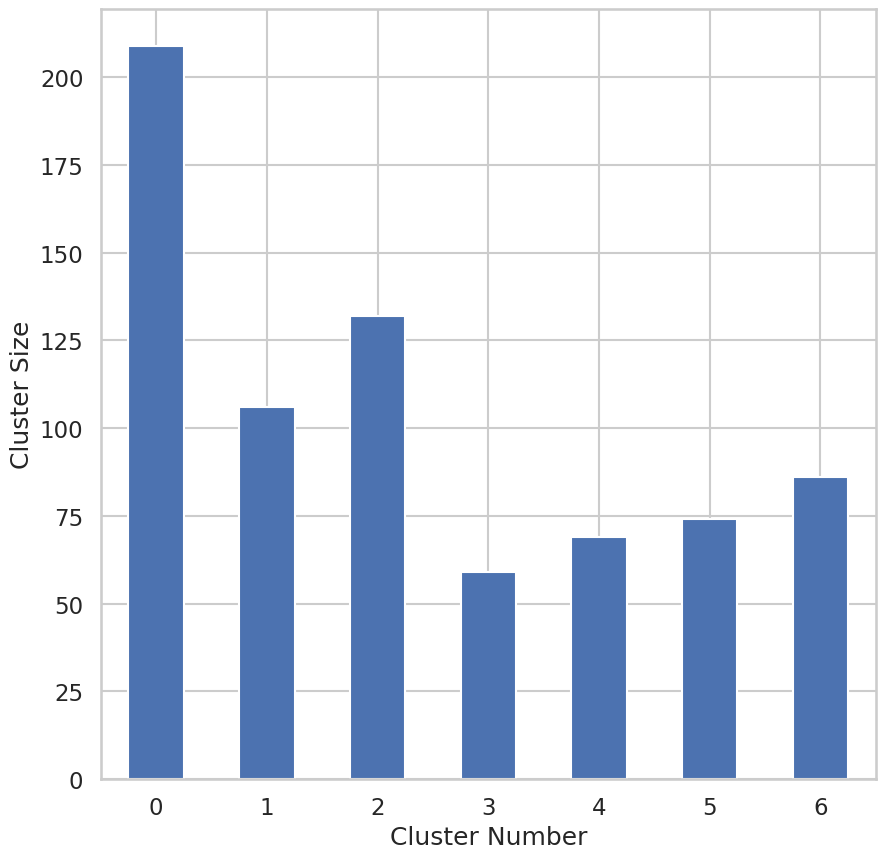

In [122]:
ax = pd.Series(agg_labels).value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

One potential drawback of k-means clustering is that it requires you to specify the number of clusters.  One means of determining the optimal number of clusters is by maximizing the silhouette score.

Silhouette Score =  $\frac{(a-b)}{max(a,b)}$ where **a** is the average intracluster distance and **b** is the average intercluster distance.  The Silhouette Score ranges between -1 and 1 with a vaule closer to 1 representing a good match between a point and other members of the same cluster.  

In [123]:
cluster_range = range(5,25)
score_list = []
for k in tqdm(cluster_range):
    cluster= AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    cluster_labels=cluster.fit_predict(X)
    score = silhouette_score(X,cluster_labels)
    score_list.append([k,score])

  0%|          | 0/20 [00:00<?, ?it/s]

Put the silhouette scores into a dataframe

In [124]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df.head()

,K,Silhouette Score
0,5,0.263642
1,6,0.284654
2,7,0.271367
3,8,0.221205
4,9,0.221904


Plot the silhouette scores as a function of the number of clusters

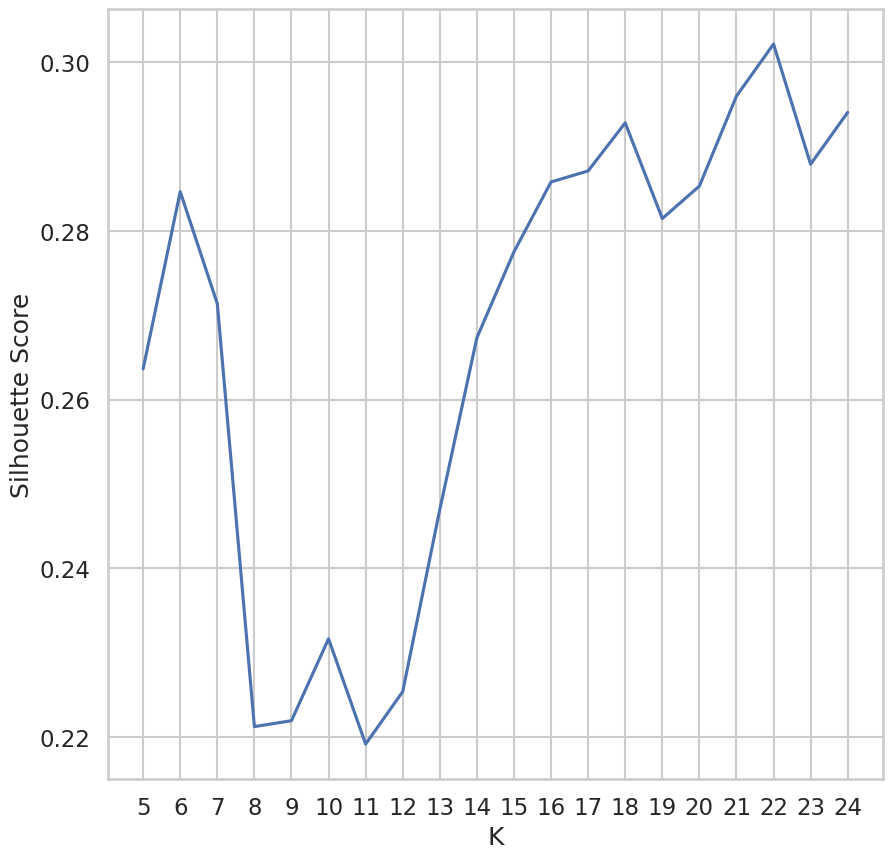

In [125]:
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In [126]:
opt_num_clusters = score_df.sort_values("Silhouette Score").K.values[0]
print(f"In the figure above the minimum silhouette score is observed with {opt_num_clusters} clusters.  Let's run KMeans with num_clusters = {opt_num_clusters}.")

In the figure above the minimum silhouette score is observed with 11 clusters.  Let's run KMeans with num_clusters = 11.


In [127]:
num_clusters = opt_num_clusters
cluster= AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
cluster_list=cluster.fit_predict(X)

Routine to plot a silhouette plot

In [128]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[])
    ax.yaxis.grid(False)

Plot a sihouette plot for the clustering above.  When we do this, we're looking for two things.
1. How uniform are the sizes of the clusters (represeneted by the widths of the bars in the plot below).
2. How consistent are the Silhoutte Scores for the inidividual clusters.

In the plot below, the red dashed line shows the average silhouette score for the clusters.  Are the peaks for each cluster near the line.  Usually there are one or two outliers.

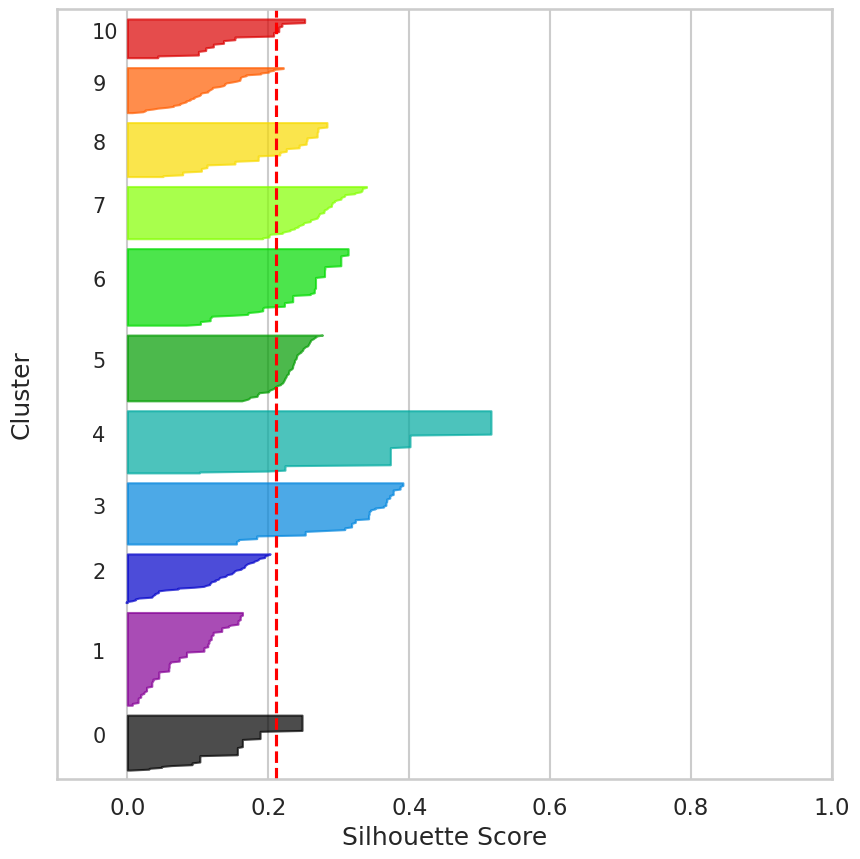

In [129]:
silhouette_plot(X,clusters_opt)

Make a TSNE plot of the clustering

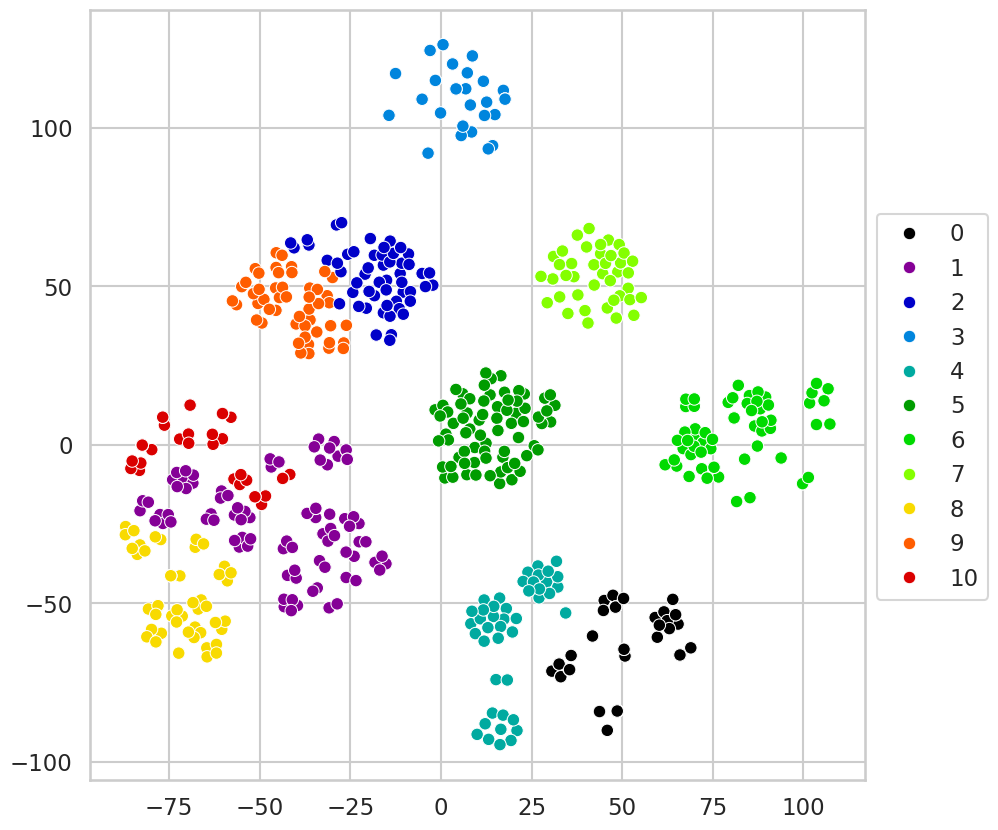

In [130]:
tsne = TSNE(n_components=2, init='pca',learning_rate='auto')
crds = tsne.fit_transform(X,clusters_opt)
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=clusters_opt,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

Add a cluster column to our input dataframe

In [131]:
opt_cluster_df = df.copy()
opt_cluster_df['Cluster'] = clusters_opt

Display structures of the cluster members

In [132]:
cluster_id = 1
cols = ["SMILES","Name","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
mols2grid.display(display_df,subset=["img"],n_cols=3,size=(320,240))

MolGridWidget()

Write the clusters to a csv file

In [133]:
opt_cluster_df[["SMILES","Name","Cluster"]].to_csv("clusters.csv",index=False)